# FINAL CLEANING AND DATA QUALITY CHECKS

Along this script we are going to undertake the following tasks:

1. Nulls
2. Duplicates analysis
3. Orders Analysis (outliers)
4. Dates Analysis (Completness of data)



## 0. Index

<a href='#a1'>1. Importing libraries and storing the dataframe in memory</a>


<a href='#a2'>2. Parsing column types</a>

<a href='#a21'>2.1. NULLs Analysis</a>

<a href='#a22'>2.2. Parsing column "units_ordered" to int</a>

<a href='#a3'>3. Duplicates Analysis</a>

<a href='#a4'>4. File Shape (one line per day-store-product)</a>

<a href='#a5'>5. Checking for outliers</a>

<a href='#a51'>5.1. Defining the outliers</a>

<a href='#a52'>5.2. Setting a threshold</a>

<a href='#a6'>6. Completeness of data</a>

<a href='#a7'>7. Storing the dataset</a>

<a href='#a8'>8. Plotting the data</a>

# 1. Importing libraries and storing the dataframe in memory<a id='a1'></a>

In [1]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


%matplotlib inline
pd.options.display.max_columns = None

In [2]:
# Defining the search path of the file, the name and the separator:

file_path = "../data/01_raw/"
file_name = "0_original_b2-transactions.csv" #'b2-transactions_sample.csv' 
exit_path = "../data/02_intermediate/"
original_file_path = file_path + "0_original_b2.csv"

exit_path_processed = "../data/03_processed/"
exit_file = "1_filtered_transactions_clean.csv"

# Create folder if not exists
try:
    os.mkdir(exit_path_processed)
except OSError:
    print ("Path %s already exists" % exit_path)

# Column names
col_names = ["product_id",
          "description",
          "order_date",
          "section",
          "BmUP",
          "VeUp",
          "CzUP",
          "AaUP",
          "SeUP",
          "JPUP",
          "RzUP",
          "AeUP",
          "LiUP",
          "EnUP",
          "GoUP",
          "GrUP",
          "AnUP",
          "MoUP",
          "PoUP",
          "MsUP",
          "ViUP",
          "ZiUO",
          "GeUP"]

filtered_file_name="c1-filtered_transactions.csv"

target_products_file_name = exit_path + 'filtered_transactions_not_clean.csv' 

sep=";"

Path ../data/02_intermediate/ already exists


In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')

df_transactions_filtered = pd.read_csv(target_products_file_name, sep = sep, parse_dates=['order_date'], encoding='latin-1', date_parser=dateparse)

In [4]:
df_transactions_filtered.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,2008-01-01,0,VeUp,"20,00",croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,2008-01-01,0,VeUp,"4,00",palmera de trufa,palmera chocolate
2,101.0,CROISSANT,2008-01-01,0,VeUp,"0,00",croissant,croissant simple
3,103.0,CROISSANT PETIT,2008-01-01,0,VeUp,"18,00",croissant petit,croissant petit
4,112.0,TORTELES,2008-01-01,0,VeUp,"60,00",torteles,tortel


In [5]:
df_transactions_filtered.shape

(968107, 8)

In [6]:
df_transactions_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968107 entries, 0 to 968106
Data columns (total 8 columns):
product_id                   968107 non-null float64
description                  968107 non-null object
order_date                   968107 non-null datetime64[ns]
section                      968107 non-null int64
store                        968107 non-null object
units_ordered                967793 non-null object
desc_normalized              968107 non-null object
target_names_prod_by_prod    968107 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 59.1+ MB


"order_date" should be date-type but is not, and "units_ordered" should be numeric, but they are not, and there are some nulls... Let's treat the nulls before parsing to the right types. 

Before continuing, let's parse the dataframe to the right column types:

# 2. Parsing column types<a id='a2'></a>

Before cleaning column "units_ordered" we need to clean the null values. Then we will be able to parse it to the right numeric type, which is int.

### 2.1. NULLs Analysis<a id='a21'></a>

In [7]:
df_transactions_filtered.isnull().sum()

product_id                     0
description                    0
order_date                     0
section                        0
store                          0
units_ordered                314
desc_normalized                0
target_names_prod_by_prod      0
dtype: int64

As we saw before, there are only nulls in "units_ordered". The good news is that it does seem to be many of them, let's have a look at it before we decide what to do to them:

After some debate, messy EDA, and careful consideration we decided to eliminate the lines for the following reasons:

1) It is possible that these lines constitute "duplicates" (duplicated in all but their values) for lines that hold a value. If this is the case, these lines would be treated as duplicates in the next step of the quality checks (in which we will see that dropping duplicates is the right move).

2) In case that these lines are not duplicated in the rest of the dataset, removing them will make no difference because we currently don't have the real value of number of units placed in the order, so, when the time comes and we will check for missing value in the series, we will appropriately deal with the matter.

In [8]:
# Proving point 1: lines with nulls may be due to duplicates 
df_original = pd.read_csv(original_file_path, sep = sep, encoding = "ISO-8859-1",names = col_names )
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
774282,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"2,00","5,00","2,00","2,00","8,00","3,00","2,00","0,00","0,00","3,00","2,00","4,00","4,00","3,00","0,00","0,00","0,00","0,00","0,00"
781175,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","5,00","0,00","0,00","0,00"


As mentioned above, the smartest option is to eliminate lines with NaN in the unit ordered: 

In [9]:
df_transactions_filtered_nan_removed = df_transactions_filtered.dropna()

In [10]:
# Check
df_transactions_filtered.shape[0] - 314 == df_transactions_filtered_nan_removed.shape[0]


True

### 2.2. Parsing column "units_ordered" to int<a id='a22'></a>

In [11]:
df_transactions_filtered_nan_removed["units_ordered"]  = df_transactions_filtered_nan_removed["units_ordered"].str.split(",").apply(lambda l: int(l[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_transactions_filtered_nan_removed.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,2008-01-01,0,VeUp,20,croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,2008-01-01,0,VeUp,4,palmera de trufa,palmera chocolate
2,101.0,CROISSANT,2008-01-01,0,VeUp,0,croissant,croissant simple
3,103.0,CROISSANT PETIT,2008-01-01,0,VeUp,18,croissant petit,croissant petit
4,112.0,TORTELES,2008-01-01,0,VeUp,60,torteles,tortel


In [13]:
df_transactions_filtered_nan_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 967793 entries, 0 to 968106
Data columns (total 8 columns):
product_id                   967793 non-null float64
description                  967793 non-null object
order_date                   967793 non-null datetime64[ns]
section                      967793 non-null int64
store                        967793 non-null object
units_ordered                967793 non-null int64
desc_normalized              967793 non-null object
target_names_prod_by_prod    967793 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 66.5+ MB


Voila! the types look as they should be looking, and the nulls have been treated. 

# 3. Duplicates Analysis<a id='a3'></a>

Let's see if we have any duplicates:

In [14]:
df_transactions_filtered_nan_removed.duplicated().sum() 

120340

Wow! this was unexpected 120.340 duplicates seems as a big number (it is roughly 1/8 of the rows of the Dataset). 

We need to take a closer look to these duplicates:

In [15]:
duplicates = df_transactions_filtered_nan_removed[df_transactions_filtered_nan_removed.duplicated()]
duplicates.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
261,182.0,PALMERAS DE TRUFA,2009-01-01,0,ZiUO,0,palmera de trufa,palmera chocolate
292,182.0,PALMERAS DE TRUFA,2009-01-01,0,AeUP,0,palmera de trufa,palmera chocolate
325,182.0,PALMERAS DE TRUFA,2009-01-01,0,ViUP,0,palmera de trufa,palmera chocolate
347,182.0,PALMERAS DE TRUFA,2009-01-01,0,LiUP,0,palmera de trufa,palmera chocolate
358,182.0,PALMERAS DE TRUFA,2009-01-01,0,GeUP,0,palmera de trufa,palmera chocolate


Interesting, it seems that all have 0 units ordered, but let's dig more into this:

In [16]:
duplicates["units_ordered"].value_counts()

0     118025
1       1583
2        255
3         71
6         71
4         65
8         50
10        38
5         32
12        21
15        18
25        12
7         12
20        12
18        12
50         9
30         8
14         7
16         7
40         5
11         4
9          4
13         3
24         3
55         2
22         2
26         2
35         2
70         1
90         1
45         1
64         1
60         1
Name: units_ordered, dtype: int64

Unfortunately, it seems that not all the duplicates are 0, otherwise we could have deleted the duplicates. However we now need to find out a bit more the ones greater than 0. 

So we are going to explore the original file to see what could have happened:

Let's take for example the duplicate with "units_ordered" = 70:

In [17]:
duplicates[duplicates["units_ordered"]==70]

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
396559,112.0,TORTELES,2016-02-20,0,VeUp,70,torteles,tortel


Let's now search for this specific row in the original dataset that the client gave us:

In [18]:
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
774282,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"2,00","5,00","2,00","2,00","8,00","3,00","2,00","0,00","0,00","3,00","2,00","4,00","4,00","3,00","0,00","0,00","0,00","0,00","0,00"
781175,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","5,00","0,00","0,00","0,00"


We consider the theory that many from our duplicates might come from duplicates from the original file.

Let's check it:

In [19]:
df_original.duplicated().sum()

5282

There many duplicates in the original file, but not enough.

As we melted this file to obtain our own (and to have the information as transactions), this number of duplicates has to be multiplied by the number of stores (10), but even then it falls a little shy of the number of duplicates in our results.

Also, when we have into consideration that most of the duplicates should correspond to products that are not in our filtered dataset, we cannot consider duplicates from the original file as the only (or even, the main) source of duplicates in our file.

Diggind deeper in the matter, we are now going to check a couple of values from our duplicates, in the original dataframe provided to us:

In [20]:
df_original[(df_original["order_date"]=="20/2/2016 0:00:00")&(df_original["description"].str.contains("TORTELES"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
1462852,112.0,TORTELES,20/2/2016 0:00:00,0,"40,00","70,00","35,00","60,00","36,00","30,00","16,00","0,00","0,00","30,00","0,00","0,00","20,00","20,00","30,00","0,00","0,00","0,00","17,00"
1462883,112.0,TORTELES,20/2/2016 0:00:00,0,"0,00","70,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


We can see that the bottom line is empty except for the store "VeUp" that has the value repeated. Coincidence or patter? let's dig a bit more:

In [21]:
# Let's take a random one from:

duplicates[duplicates["units_ordered"]==4].sample()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
9576,4511.0,POSTRE FRESAS Y MASCARPONE,2015-12-01,0,BmUP,4,postres fresas y mascarpone,postre de fresas y mascarpone


In [22]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))][["product_id","description","order_date","section","RzUP"]]

,product_id,description,order_date,section,RzUP
1471806,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"1,00"
1471807,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"4,00"
1471808,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"1,00"
1473160,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"4,00"
1473665,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473671,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473694,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473695,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473778,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"


This case beneath is very interesting:
    
We can see that for a given produt id, with the same description and on the same order date, there are several orders:

* Some of these orders are duplicates

* Some lines correspond to one order from one specific store, but we have two different orders asking for diffent quantities of the product

In [23]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
1471806,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1471807,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","4,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1471808,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473160,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"3,00","4,00","0,00","5,00","0,00","2,00","4,00","0,00","0,00","1,00","0,00","0,00","3,00","1,00","3,00","0,00","0,00","0,00","0,00"
1473665,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473671,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","3,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473694,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473695,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473778,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","5,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


Ok..., at this point the information was too confusing: One store, in one day has multiple orders; all very similar.. And when that store is compared to the other stores for the same day, its even more confusing... So we decided to meet with the client and ask for clarifications:

These are the conclusions from the meeting:

 - In the original file, there should only be one line per day, if there are more it could mean two things:
     - if the additional line is all 0 except for one store, AND that store has 0 in the main line, it means that they had to manually input their order in the system.
     - if one store has duplicated orders for a given day-product, it means they made a mistake. 
 - Also, if a store orders different quantities of the same product in the same day, its probably an error and they only take the largest order.
 
 The main conclusion from the client is that we can group by Date - product - store and take the largest order to remove duplicates... HOWEVER, before doing this, we need to take into account another situation: One product could have been ordered by a store, in a given day using several different product id / descriptions. If we group by, we may be loosing orders, unless we are very restrictive. 

In [24]:
#Let's take the max value for each line:

df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id', 'description','order_date', 'section', 'store', 'desc_normalized', 'target_names_prod_by_prod']).max().reset_index()

In [25]:
df_non_duplicated_lines.duplicated().sum()

0

Perfect, we don't have duplicates!... Or yes...

Actually, we may still have duplicates, one store could have created duplicates that we have not identified by ordering the same product by two different ID's or using different descriptions.

- If they were using different ID's this could would mainly mean that they intentionally want two different orders (perhaps custom orders, and normal order)

- If they were using different product descriptions, it would probably mean that they introduced the order two times, however we are going to explore this situation a bit more:


In [26]:
# Let's count the number of times a duplicated line differs only by the raw desciption, and has a value greater than 0:

aux=df_non_duplicated_lines.drop('description', axis=1)
aux2 = aux[aux.duplicated()]
aux2[aux2["units_ordered"]>0]["units_ordered"].shape

(16,)

In [27]:
aux2["units_ordered"].max()

1

As seen, there are not a lot of values involved, neither have big weights.

Under the consideration that the total aggregated error is 16 units in a series spanning a decade and with millions of units ordered, we consider it safe to simply eliminate this transactions.

In [28]:
df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id','order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].max().reset_index()

In [29]:
df_non_duplicated_lines.head()

,product_id,order_date,section,store,target_names_prod_by_prod,units_ordered
0,45.0,2017-05-05,0,AaUP,postre de fresas y mascarpone,0
1,45.0,2017-05-05,0,AeUP,postre de fresas y mascarpone,0
2,45.0,2017-05-05,0,AnUP,postre de fresas y mascarpone,0
3,45.0,2017-05-05,0,BmUP,postre de fresas y mascarpone,0
4,45.0,2017-05-05,0,CzUP,postre de fresas y mascarpone,0


In [30]:
df_non_duplicated_lines.duplicated().sum()

0

We are going to check the resulting shape of our dataframe, to do a brief sanity check by seeing how many lines have been deleted:

In [31]:
df_non_duplicated_lines.shape

(742922, 6)

## 4. File Shape (one line per day-store-product)<a id='a4'></a>

The dataset should contain only one line per product, date, and store. However, we already know that one product could have been ordered by given store, in a given day under several products ID's. 

The expectation is that there could be several different orders for the same product, same day and same store, because, as we saw when filtering our products, there were several product IDs for most of them that checked all the boxes of the description, as we can see in the image below (corresponding to the "mousse 3 chocolates"):

<img src=./images/IM00.png>

Let's check it:

In [32]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].count()

1045

In [33]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].max()

4

For this orders we are not going to pick the biggest, as before, but sum their quantities: indeed, they have different product ids, but they correspond to the very same product, so adding up the quantities is what will give us the total ammount a particular store orders in a particular day:


In [34]:
df_to_check = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].sum().reset_index()
df_to_check.head(20)

,order_date,section,store,target_names_prod_by_prod,units_ordered
0,2008-01-01,0,AaUP,baguette,15
1,2008-01-01,0,AaUP,croissant petit,12
2,2008-01-01,0,AaUP,croissant simple,4
3,2008-01-01,0,AaUP,milhojas frambuesa,1
4,2008-01-01,0,AaUP,mousse tres chocolates,0
5,2008-01-01,0,AaUP,palmera chocolate,5
6,2008-01-01,0,AaUP,tortel,0
7,2008-01-01,0,AeUP,baguette,0
8,2008-01-01,0,AeUP,croissant petit,0
9,2008-01-01,0,AeUP,croissant simple,0


## 5. Checking for outliers<a id='a5'></a>

We are now going to check for outliers in our data.

We are going to undertake this task little by little:

In [35]:
df_to_check['units_ordered'].mean()

4.771253282574057

In [36]:
df_to_check['units_ordered'].max()

4100

The maximum is very high. Let's show the 20 highest values, to see if it is an oddity or this 4100 is not alone:

In [37]:
df_to_check.sort_values('units_ordered', ascending=False).head(20)

,order_date,section,store,target_names_prod_by_prod,units_ordered
41024,2008-10-05,0,EnUP,croissant petit,4100
11935,2008-03-23,0,EnUP,croissant petit,3600
26310,2008-06-26,0,LiUP,croissant petit,3500
267151,2012-11-03,0,EnUP,palmera chocolate,3110
39333,2008-09-24,0,EnUP,croissant petit,3100
38594,2008-09-19,0,LiUP,croissant petit,3000
41615,2008-10-09,0,LiUP,croissant petit,1800
16972,2008-04-25,0,LiUP,croissant petit,1500
3575,2008-01-27,0,EnUP,croissant petit,1200
37568,2008-09-12,0,LiUP,croissant petit,1070


This shows us that our data definitely has outliers.

Now, we are going to plot them:

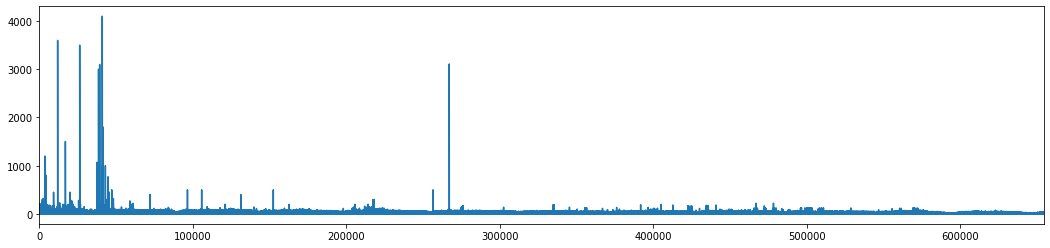

In [38]:
df_to_check['units_ordered'].plot(figsize=(18,4))

Same plot eliminating the largest values up to a threshold:

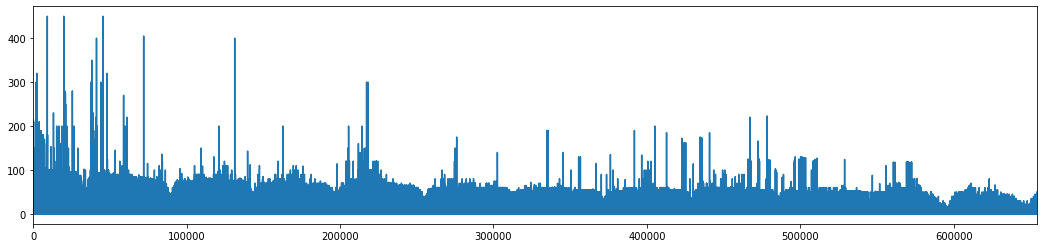

In [39]:
n=500

df_to_check[df_to_check['units_ordered']<n]['units_ordered'].plot(figsize=(18,4))

As we can see, now our values present a more coherent shape.

Now, plotting a histogram of our values to see

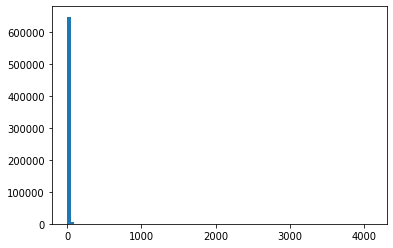

In [40]:
histo1=plt.hist(df_to_check['units_ordered'], bins=82)

In [41]:
histo1

(array([6.47357e+05, 6.85800e+03, 2.67000e+02, 4.90000e+01, 2.40000e+01,
        5.00000e+00, 7.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00,
        5.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

Seeing that most of the weight is between 0 and 100 (and we cannot see a thing), we plot the same, but for values higher than 100:

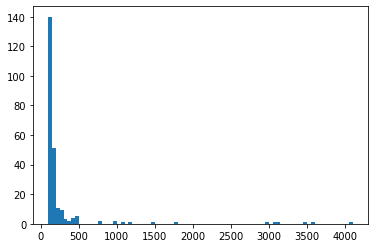

In [42]:
histo2=plt.hist(df_to_check[df_to_check['units_ordered']>100]['units_ordered'], bins=80)

In [43]:
histo2

(array([140.,  51.,  11.,   9.,   3.,   2.,   4.,   5.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([ 101.    ,  150.9875,  200.975 ,  250.9625,  300.95  ,  350.9375,
         400.925 ,  450.9125,  500.9   ,  550.8875,  600.875 ,  650.8625,
         700.85  ,  750.8375,  800.825 ,  850.8125,  900.8   ,  950.7875,
        1000.775 , 1050.7625, 1100.75  , 1150.7375, 1200.725 , 1250.7125,
        1300.7   , 1350.6875, 1400.675 , 1450.6625, 1500.65  , 1550.6375,
        1600.625 , 1650.6125, 1700.6   , 1750.5875, 1800.575 , 1850.5625,
        19

In [44]:
histo2[0].sum()

239.0

Only 239 values are greater than 100, and even being such the case, most of them (191 from the 239 values) have values not superior to 200, what leaves us with only 48 values greater than 200.

And, finally, let's take a look on this extreme data:

In [45]:
df_to_check[df_to_check['store']=='EnUP'].sort_values('units_ordered', ascending=False).head(10)

,order_date,section,store,target_names_prod_by_prod,units_ordered
41024,2008-10-05,0,EnUP,croissant petit,4100
11935,2008-03-23,0,EnUP,croissant petit,3600
267151,2012-11-03,0,EnUP,palmera chocolate,3110
39333,2008-09-24,0,EnUP,croissant petit,3100
3575,2008-01-27,0,EnUP,croissant petit,1200
152498,2010-10-19,0,EnUP,croissant simple,500
47199,2008-11-16,0,EnUP,croissant petit,500
105801,2009-11-25,0,EnUP,croissant simple,500
96548,2009-09-30,0,EnUP,croissant simple,500
256660,2012-08-29,0,EnUP,croissant petit,500


And compare it with the average values for an specific product:

In [46]:
aux3=df_to_check.groupby(['store', 'target_names_prod_by_prod']).mean().reset_index()

aux3[aux3['store']=='EnUP']

,store,target_names_prod_by_prod,section,units_ordered
50,EnUP,baguette,0.0,0.000000
51,EnUP,croissant petit,0.0,19.159587
52,EnUP,croissant simple,0.0,40.303379
53,EnUP,milhojas frambuesa,0.0,0.211069
54,EnUP,mousse tres chocolates,0.0,0.449353
55,EnUP,palmera chocolate,0.0,4.814232
56,EnUP,postre de fresas y mascarpone,0.0,0.066814
57,EnUP,tarta de manzana,0.0,0.111398
58,EnUP,tarta opera,0.0,0.309478
59,EnUP,tortel,0.0,44.982168


It can be seen that the peaks numbers for this particular store are between 25 and 200 times their mean order.

**First preliminary conclussions:**

Again, we can see that, in our whole data, only 239 values are greater than 100, and even being such the case, most of them (191 from the 239 values) have values not superior to 200, what leaves us with only 48 values greater than 200.

Even though, this data could be anomalies in the time series explained by events.

Football matches, national or local holidays, or large custom orders, such as weddings, could be the reason for this strange data.

But, as the focus of our project is not at large custom orders (indeed, the client handles them ad hoc, and what it has asked us to do is to provide a solution for the day-to-day orders), there is very little interest for us in such kind of anomalies.

However, we are interested in trying to keep the effects of everyday events such as football matches, holidays or the weather, in the daily orders from the stores to the factory.

So, perhaps keeping an intermediate threshold would do the trick, because:

* the very large values are just a few and can be only due to a mistake in the order or due to large custom orders from specific clients for special events,


* keeping at the same time some of the high values (high, but not extravagantly high), that are not produced by the effects above, but to the ones that we are interested in trying to encompass and explain with our model.

**But:**

Before proceeding to do so, there is still an interesting question pending: is this phenomenom appearing because of our operations with the data, or does it come from the original dataset?

These anomalous points are perhaps suggesting that we have done something wrong along the way, what it is important because it would force us to find where we have mishandled the data and created this spureous values.

So, to check wether this is the case, we are going to check the highest values in our original dataset now:

In [47]:
df_original2=df_original.dropna()

stores=list(df_original2.columns[4:])

results_dict=dict()
total_list=list()

for element in stores:
    
    values=df_original2[element]
    
    values2=values.str.split(",").apply(lambda l: int(l[0]))
    
    total_list.append(list(values2))
    
    results_dict[element]=values2

print(values2.sort_values(ascending=False)[:10])

320290     1210
44061       400
224278      300
45286       300
1409477     300
1409476     300
535338      300
97221       300
224277      300
311534      300
Name: GeUP, dtype: int64


In [48]:
total_list_flat = [item for sublist in total_list for item in sublist]

For starters, we take the series of values for the last store and take a look on it:

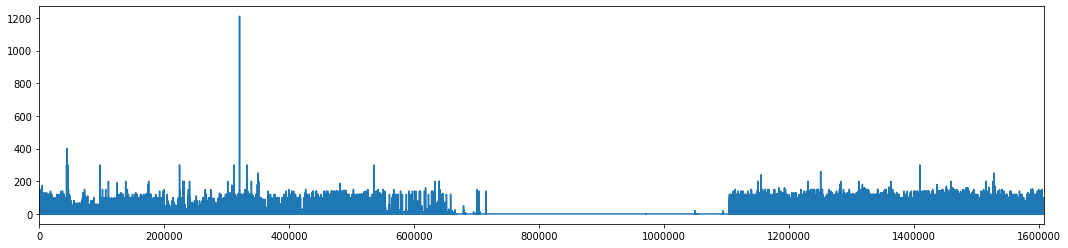

In [49]:
values2.plot(figsize=(18,4))

We can see that there is just one value that is disproportionatelly large when compared to the rest, and that by removing this extreme value the series presents a much better appearance:

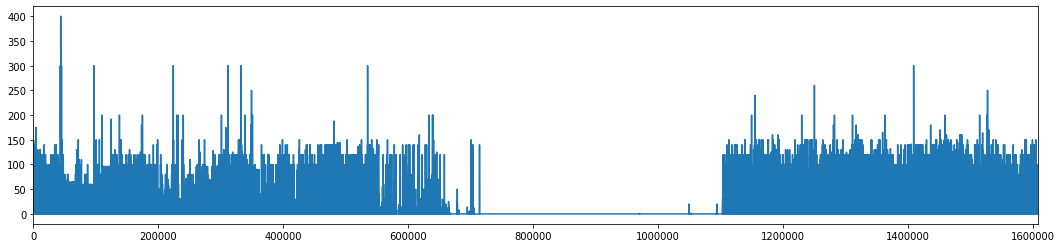

In [50]:
to_drop=values2[values2==values2.max()].index

values2.drop(to_drop, inplace=True)
values2.plot(figsize=(18,4))

We now want to examine the results for another different store:

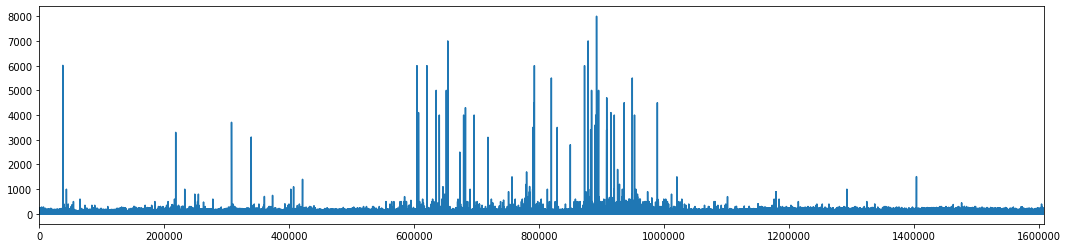

In [51]:
results_dict['EnUP'].plot(figsize=(18,4))

Again, we use a threshold:

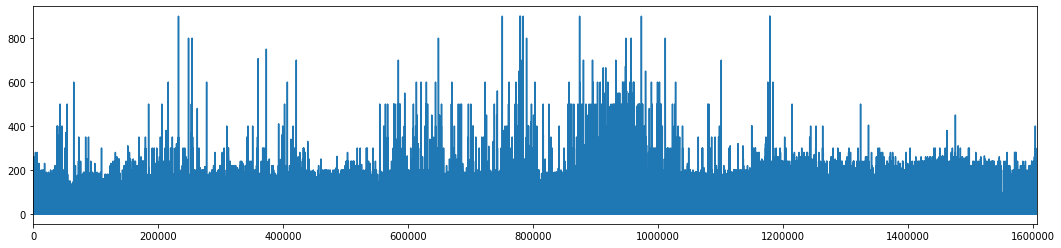

In [52]:
n=1000

enup_values=results_dict['EnUP']

enup_values[enup_values<n].plot(figsize=(18,4))

And, again, removing only just a bunch of the values leaves us with a much more beautiful series.

Then, we plot the whole list of values, regardless of their store:

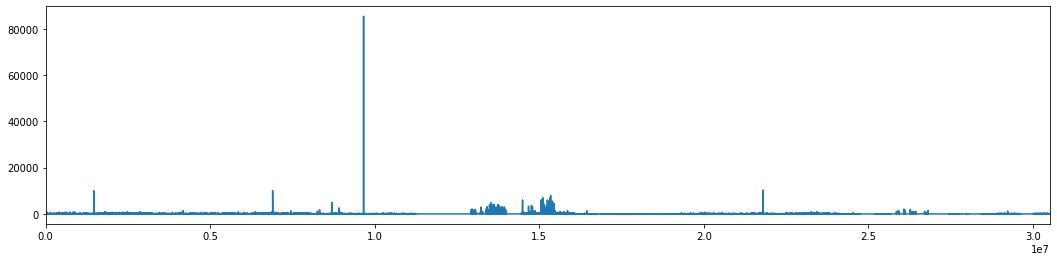

In [53]:
pd.Series(total_list_flat).plot(figsize=(18,4))

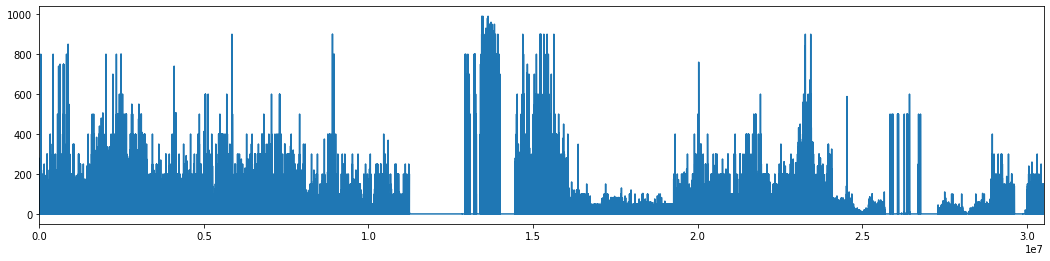

In [54]:
n=1000

values_to_plot=pd.Series(total_list_flat)

values_to_plot[values_to_plot<n].plot(figsize=(18,4))

As we can see, the bevahiour observed in our data is also observed in the original data.

**Finally:**

We have checked that the behaviour of the data from our original dataset matches the one of our series. But, to be completely sure that our high-valued anomalies come from our original data we are going to check wether the values in our series exist in the original dataset or they do not:

In [55]:
total_list_set=set(total_list_flat)

In [56]:
our_set=set(df_to_check['units_ordered'])

In [57]:
our_set-total_list_set

{405}

There is only one value that it is not in both sets, which probably means that all our high value peaks come from the original dataset, and not from mishandling our data.

Why is it so? Because, as we go towards higher values, the distributions of appearances of a certain value in our total orders diminish, and the presence of any values above 500 becomes scarcer and scarcer.

Our orders are a sum of the orders of one or several products of our original dataset. So, if the quantities didn't match, we would nt be able to conclude a thing from this test, and several posterior checks should be undertaken.

But it is not probable that a number that appears both in our order series and the original file is a result of a sum of other orders of the original file (it would be very strange that a sum of small values would hit on a high value that IS PRESENT in the original series of sales). 

The opposite, instead, is what one can expect.

Knowing that it is not a rigorous proof, but an statistical one, but seeing that our test has been passed extremely well, we can assume that all our anomalous data comes directly from outliers from the original dataset, and not from a mishandling.

After all, we are doing Data Science.



## 5.1. Defining the outliers<a id='a51'></a>

So, having checked that the resulting outliers with a high degree of probability come directly from our original dataset, now we want to create the convenient strategy to process the outliers.

In [58]:
df_to_check.head()

,order_date,section,store,target_names_prod_by_prod,units_ordered
0,2008-01-01,0,AaUP,baguette,15
1,2008-01-01,0,AaUP,croissant petit,12
2,2008-01-01,0,AaUP,croissant simple,4
3,2008-01-01,0,AaUP,milhojas frambuesa,1
4,2008-01-01,0,AaUP,mousse tres chocolates,0


In [59]:
stats_with_outliers=df_to_check.groupby('target_names_prod_by_prod')["units_ordered"].agg(['mean', 'max', 'median', 'std']).reset_index()

stats_with_outliers['deviation_max']=(stats_with_outliers['max']-stats_with_outliers['mean'])/stats_with_outliers['std']

stats_with_outliers

,target_names_prod_by_prod,mean,max,median,std,deviation_max
0,baguette,6.251770,300,5,8.751807,33.564294
1,croissant petit,4.212664,4100,3,30.807728,132.946751
2,croissant simple,8.591148,770,6,12.820000,59.392266
3,milhojas frambuesa,0.839823,38,0,1.283865,28.944001
4,mousse tres chocolates,0.087265,125,0,0.858856,145.440775
5,palmera chocolate,2.356105,3110,2,11.205969,277.320400
6,postre de fresas y mascarpone,4.399655,120,4,4.568834,25.301936
7,tarta de manzana,0.793862,280,1,1.717607,162.555287
8,tarta opera,0.090909,270,0,2.736694,98.625961
9,tortel,12.768036,405,8,16.805164,23.339966


From the table above we can see that the maximum value for each category is between 23 and 277 standard deviations away from the mean.

Assuming (boldly) that our data should follow normal or Poisson-like distributions, these kinds of events should be considered very anomalous (probability ~ 0).

**Ploting the data**

We are going to put a face and a name on this anomalies, by plotting them:

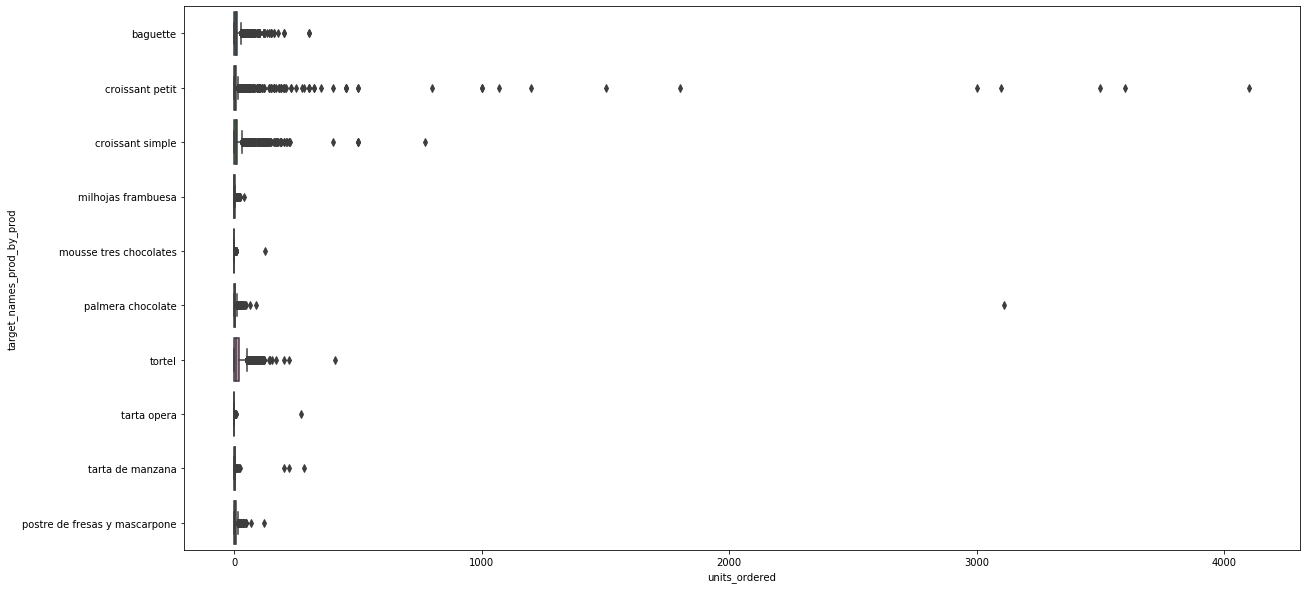

In [60]:
plt.figure(figsize=(20,10))
sns.boxplot(df_to_check['units_ordered'], df_to_check['target_names_prod_by_prod'], orient='h')

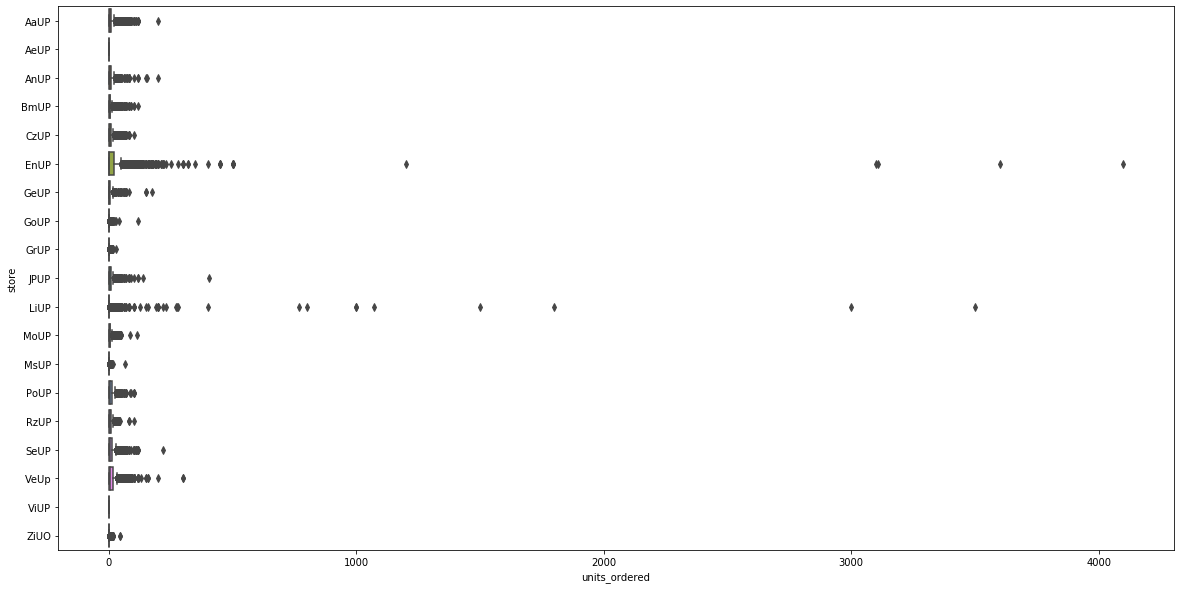

In [61]:
plt.figure(figsize=(20,10))
sns.boxplot(df_to_check['units_ordered'], df_to_check['store'], orient='h')

As we cannot "see" properly, again because of the influence of the extremals, we are going to remove values over 200 (remember that there were only 48 values in our data that exceeded this value) of our series and then we are going to plot them again:

In [62]:
df_to_hist = df_to_check[df_to_check['units_ordered']<=200]

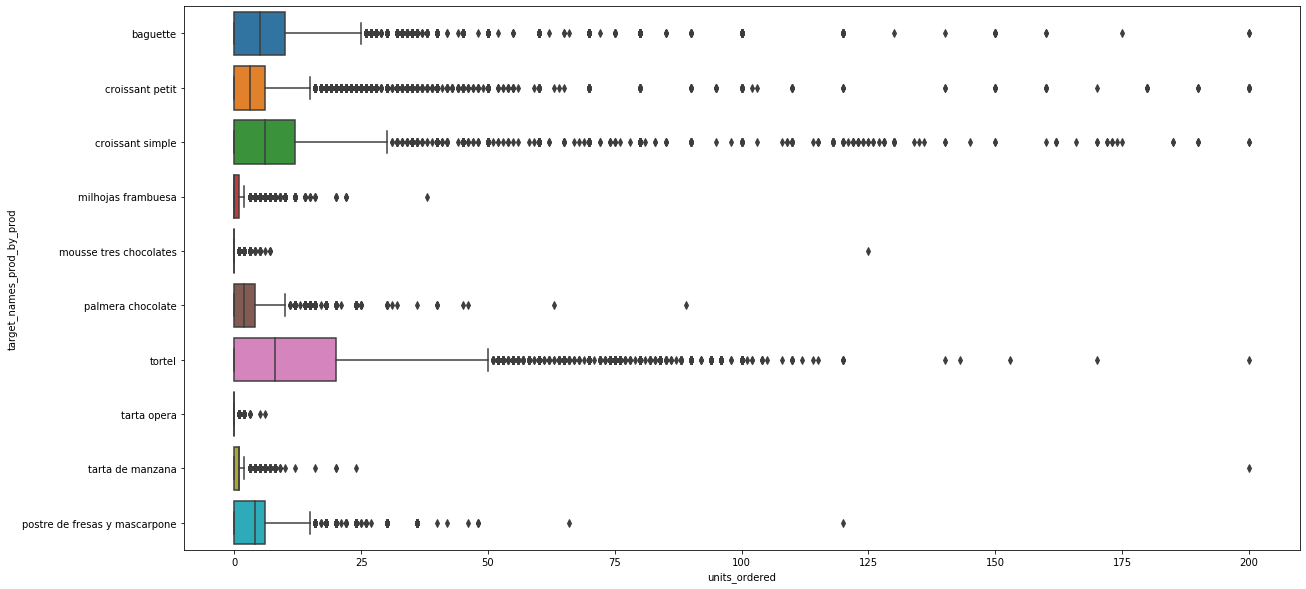

In [63]:
plt.figure(figsize=(20,10))
sns.boxplot(df_to_hist['units_ordered'], df_to_hist['target_names_prod_by_prod'], orient='h')

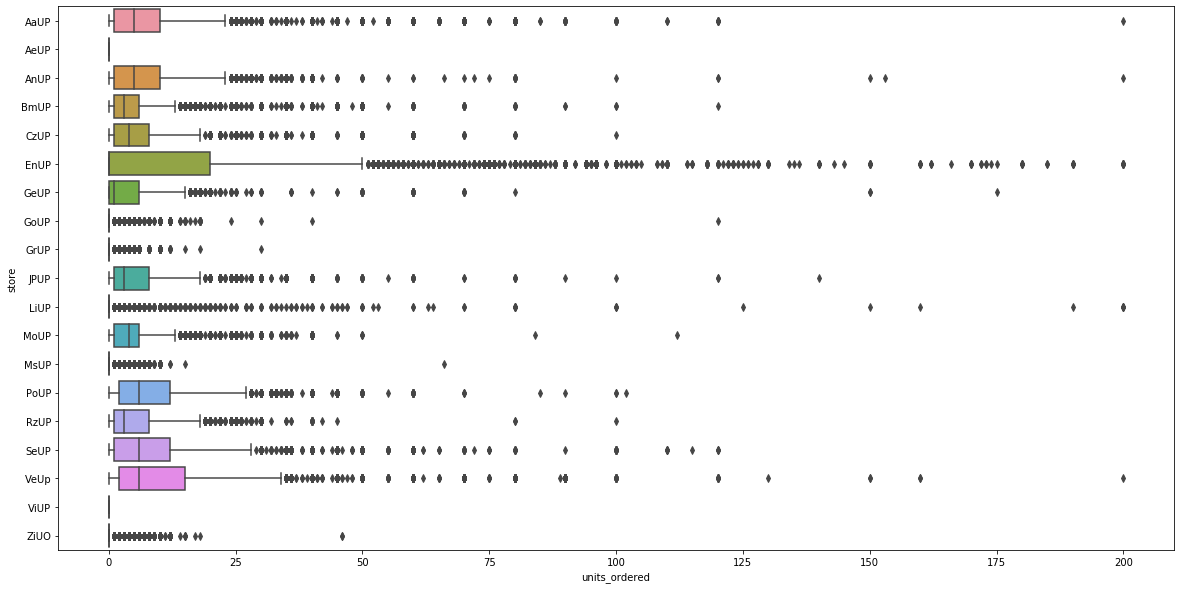

In [64]:
plt.figure(figsize=(20,10))
sns.boxplot(df_to_hist['units_ordered'], df_to_hist['store'], orient='h')

As we can see, it doesn't matter wether we group the orders by product or by store, these values are always extreme.

## 5.2. Setting a threshold<a id='a52'></a>

The procedure we will follow consists of trying out different thresholds based in standard deviations from the mean, and checking how many data point in our series we are elliminating by selecting that particular threshold.

Indeed, as we stated above, there are only 49 values for our series that have values over 200.

Replacing them conviniently by a median value, a mean of the series or a mean based on neighbous should not distort our data.

But also, as we said previosly, we do not want to remove too many points, that might be caused by anomalies that we want to study.

The thresholds we are going to apply will be based in a certain number of standard deviations of the mean. We will then check how many points meet this condition, and adjust our values accordingly:

In [65]:
# Lest calculate how many values per product are outliers depending 
# on the number of number of standard desviatons

standard_desviations = [2,3,4,5,6,7,8,9,10]
results = pd.DataFrame()


for product in df_to_check["target_names_prod_by_prod"].unique():
    for d in standard_desviations:        
        vals = stats_with_outliers.loc[stats_with_outliers["target_names_prod_by_prod"]== product, ["mean","std"]]
        threshold = (vals["mean"] + vals["std"] * d).iloc[0]

        q1 = (df_to_check["target_names_prod_by_prod"]==product)
        q2 = (df_to_check["units_ordered"] <= threshold)

        df_aux = df_to_check[q1 & q2]

        results = results.append (pd.Series([product, d ,q1.sum() - df_aux.shape[0]]), ignore_index=True)
       
    
results.columns = ["product", "std", "n_outliers"]
results


,product,std,n_outliers
0,baguette,2.0,2854.0
1,baguette,3.0,873.0
2,baguette,4.0,379.0
3,baguette,5.0,249.0
4,baguette,6.0,245.0
5,baguette,7.0,177.0
6,baguette,8.0,106.0
7,baguette,9.0,63.0
8,baguette,10.0,57.0
9,croissant petit,2.0,129.0


In [66]:
results.groupby('std').sum()

,n_outliers
std,
2.0,17165.0
3.0,7181.0
4.0,2728.0
5.0,983.0
6.0,593.0
7.0,444.0
8.0,289.0
9.0,182.0
10.0,147.0


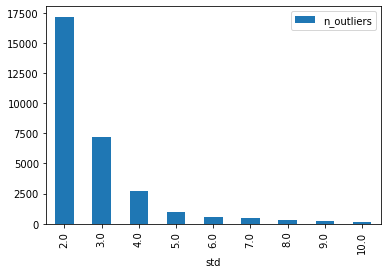

In [67]:
# Number of outliers per standard desviation
results.groupby('std').sum().plot.bar()

It is hard to make a decision on what is the ideal number of standard deviations to consider a value an outliers. On the one hand, we want to remove as few values as possible, to distort the data as little as we can. On the other hand, we want to be sure that we are removing all this anomalous data so it will not influence our predictions.

As we now from the 68-95-99.7 rule, in a normal distribution only 0.3% of the values are more than 3 standard deviations away from the mean.

As we stated above, we do not expect our data to follow a Gaussian distribution (in any case, we would go for something reminding a Poisson).

As it can be seen above, taking 3 standard deviations would remove too many points of our series.

As we also saw previously, only 49 points in our series have a value over 200.

It is for these reasons that we decided to consider an outlier 6 standard deviations, which - according to the barplot plotted above - is the point where the  slope smoothens.

Now, we need to treat the outliers - we don't want to just remove them; it would't make sense since an outlier probably means two things:
    
- The store made a mistake with the number ordered.
- It was an extraordinary order (wedding?)

Either case is an order to the factory hence replacing the outlier with the mean or median would be more realistic. (mode, in this case would be 0)

In [68]:
# Let's create two datasets with the outliers replaced. One with the mean of the product, 
#the other with the median:by the mean

d = 4
results = pd.DataFrame()
dfs = []

df_outliers_mean = df_to_check.copy()
df_outliers_median = df_to_check.copy()


for product in df_to_check["target_names_prod_by_prod"].unique():

    vals = stats_with_outliers.loc[stats_with_outliers["target_names_prod_by_prod"]== product, ["mean","std","median"]]
    threshold = (vals["mean"] + vals["std"] * d).iloc[0]

    q1 = (df_to_check["target_names_prod_by_prod"]==product)
    q2 = (df_to_check["units_ordered"] >= threshold)
    
    df_outliers_mean.loc[q1 & q2,"units_ordered"] =  vals["mean"].iloc[0]
    df_outliers_median.loc[q1 & q2,"units_ordered"] =  vals["median"].iloc[0]


Let's now plot the series of the order values:

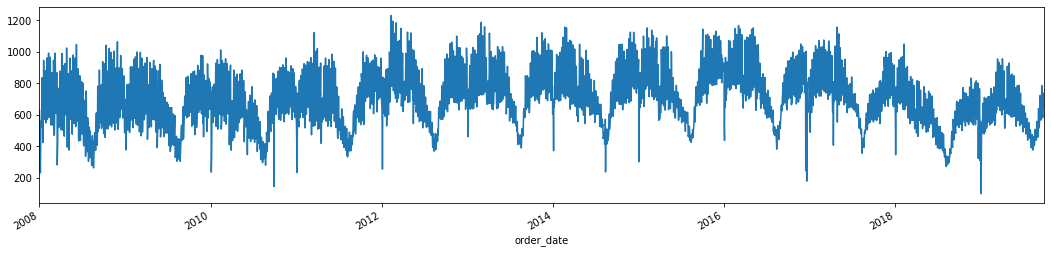

In [69]:
df_outliers_mean.groupby('order_date')['units_ordered'].sum().plot(figsize=(18,4))

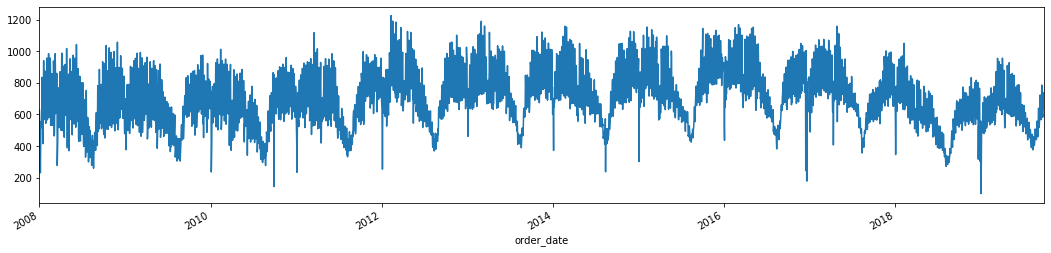

In [70]:
df_outliers_median.groupby('order_date')['units_ordered'].sum().plot(figsize=(18,4))

And, again, the histogram to take a look on how the filtering resulted:

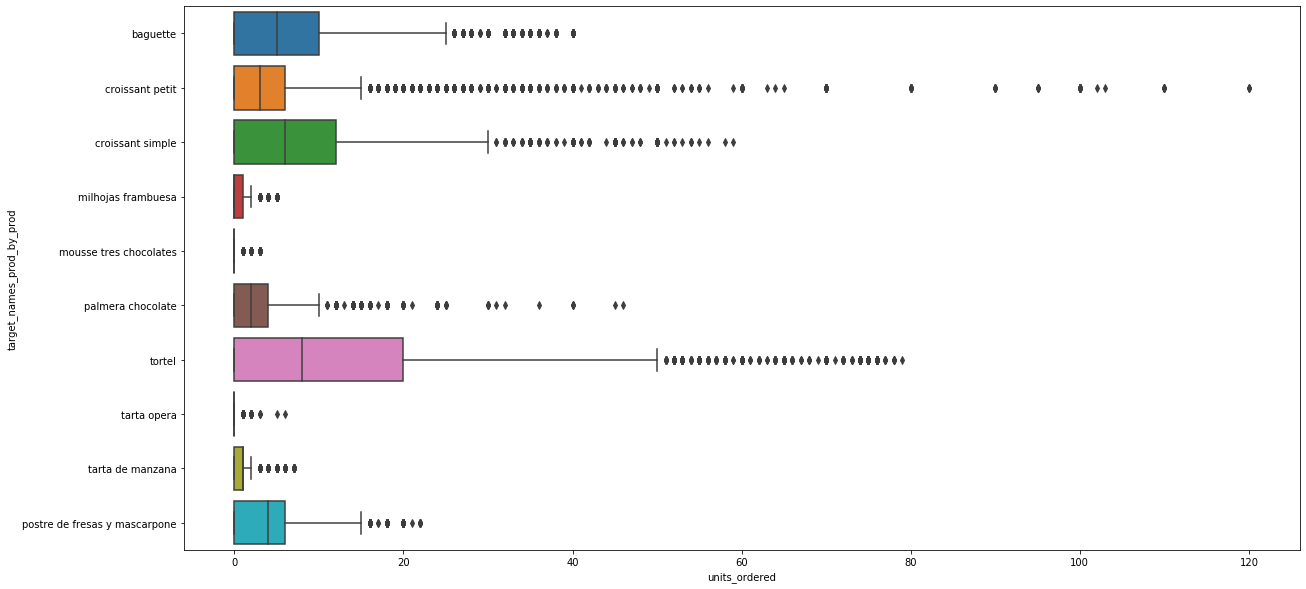

In [71]:
plt.figure(figsize=(20,10))
sns.boxplot(df_outliers_median['units_ordered'], df_outliers_median['target_names_prod_by_prod'], orient='h')

In [72]:
df_outliers_mean[~(df_outliers_mean["units_ordered"] == df_outliers_median["units_ordered"])].head()

,order_date,section,store,target_names_prod_by_prod,units_ordered
41,2008-01-01,0,EnUP,tortel,12.768036
165,2008-01-03,0,EnUP,croissant simple,8.591148
168,2008-01-03,0,EnUP,tortel,12.768036
284,2008-01-04,0,EnUP,croissant simple,8.591148
288,2008-01-04,0,EnUP,tortel,12.768036


In [73]:
df_outliers_median[~(df_outliers_mean["units_ordered"] == df_outliers_median["units_ordered"])].head()

,order_date,section,store,target_names_prod_by_prod,units_ordered
41,2008-01-01,0,EnUP,tortel,8
165,2008-01-03,0,EnUP,croissant simple,6
168,2008-01-03,0,EnUP,tortel,8
284,2008-01-04,0,EnUP,croissant simple,6
288,2008-01-04,0,EnUP,tortel,8


**To median or to mean... that is the question:**

This is a hard one, both have pros and cons. However we decided to keep the outliers replaced by the median for the following reasons:

- its more realistic (the values are already integers, while, for the mean, they are real numbers that we should transform)
- the mean was calculated before removing the outliers (so, it has their influence, although it shouldn't be very marked, according to their proportion in our data)

Great! let's now check how complete is our dataset.

## 6. Completeness of data<a id='a6'></a>

What we are going to check now is that for the date-range of our dataset, we have values for all days.

In [74]:
# First, let's calculate our date-range:
daterange = pd.date_range(df_outliers_median["order_date"].min(), df_outliers_median["order_date"].max())
daterange.shape[0]

4291

In [75]:
# Now let's compare the date-range with the number of values that we have per day per product:

days_per_product = {}

for product in df_outliers_median["target_names_prod_by_prod"].unique():
    days = df_outliers_median.loc[df_outliers_mean["target_names_prod_by_prod"]== product, "order_date"].unique().shape[0]
    days_per_product[product] = days

In [76]:
days_per_product

{'baguette': 3890,
 'croissant petit': 4261,
 'croissant simple': 4262,
 'milhojas frambuesa': 4265,
 'mousse tres chocolates': 1313,
 'palmera chocolate': 4258,
 'tortel': 4262,
 'tarta opera': 517,
 'tarta de manzana': 4258,
 'postre de fresas y mascarpone': 3173}

We have not enough data for the prediction for some of the products. But we will deal with this problem later.

Let's now fill the missing dates with 0:

To do so, we are going to create a dataset with the full range of dates, products and stores. Then, we will make a left join of this dataset with out own: the matched values will keep the record of our original dataset, and for the rest we will fill the NAs with 0s:

So, we first create three datasets, one for each variable:

In [77]:
datelist=pd.DataFrame(daterange,columns = ["order_date"] )
datelist["join_col"] = 1

In [78]:
products=pd.DataFrame(df_outliers_median['target_names_prod_by_prod'].unique(),columns = ["target_names_prod_by_prod"] )
products["join_col"] = 1

In [79]:
stores=pd.DataFrame(df_outliers_median['store'].unique(),columns = ["store"] )
stores["join_col"] = 1

Then, we merge them:

In [80]:
to_be_joined1=datelist.merge(products, on='join_col')

In [81]:
to_be_joined1.shape

(42910, 3)

In [82]:
to_be_joined2=to_be_joined1.merge(stores, on='join_col')

In [83]:
to_be_joined2.shape

(815290, 4)

Before doing the join on the left side, let's check that the inner takes all the information and matches all the values of our dataset:

In [84]:
cols=['order_date','target_names_prod_by_prod', 'store','units_ordered']

to_be_joined2.merge(df_outliers_median, on =['order_date','target_names_prod_by_prod','store'])[cols].shape

(654593, 4)

When compared to the shape of our dataframe, we see that we get the same number of lines: a signal that we are taking each and every line of our dataset.

In [85]:
df_outliers_median.shape

(654593, 5)

And now, we can proceed to do the left join:

In [86]:
cols=['order_date','target_names_prod_by_prod', 'store','units_ordered']

our_dataset=to_be_joined2.merge(df_outliers_median, on =['order_date','target_names_prod_by_prod','store'], how='left')[cols]

our_dataset.shape

(815290, 4)

We now proceed to check that the ammount of NA values matches the difference in size of our dataset and the dataset that we created with all the dates, stores, and products:

In [87]:
na_count=our_dataset[our_dataset['units_ordered'].isna()].shape[0]

diff_in_shapes=(to_be_joined2.shape[0]-df_outliers_median.shape[0])

print(na_count)
print(diff_in_shapes)
print(na_count-diff_in_shapes)

160697
160697
0


Finally, we can proceed to fill the NAs with values:

In [88]:
our_dataset.fillna(0, inplace=True)

# ATENTION!

# ADDED (UNTIL NEXT POINT):

In [104]:
from datetime import datetime

In [91]:
import datetime as dt

In [93]:
our_dataset2 = our_dataset.copy()

In [94]:
f1 = our_dataset2[our_dataset2['target_names_prod_by_prod']=='baguette']

f2 = f1[f1['store']=='AeUP']
        
f2.loc[f2['order_date']== datetime.strptime('01-03-2008', '%d-%m-%Y'), 'units_ordered'].values

array([0.])

result = pd.DataFrame()

for product in our_dataset2['target_names_prod_by_prod'].unique():
    
    filtered1 = our_dataset2[our_dataset2['target_names_prod_by_prod']==product]

    for store in filtered1['store'].unique():

        filtered2 = filtered1[filtered1['store']==store]

        for date1 in filtered2['order_date']:

            if date1 != datetime.strptime('01-01-2008', '%d-%m-%Y'):
                
                if filtered2.loc[filtered2['order_date']==date1, 'units_ordered'].values==0:

                    date2 = date1 + dt.timedelta(days=1)
                    date3 = date1 + dt.timedelta(days=-1)

                    filtered2.loc[filtered2['order_date']==date1, 'units_ordered'] = (filtered2.loc[filtered2['order_date']==date2, 'units_ordered'] +
                                                                                            filtered2.loc[filtered2['order_date']==date3, 'units_ordered'])/2

        result.append(filtered2)

result.head()

In [97]:
our_dataset.columns

Index(['order_date', 'target_names_prod_by_prod', 'store', 'units_ordered'], dtype='object')

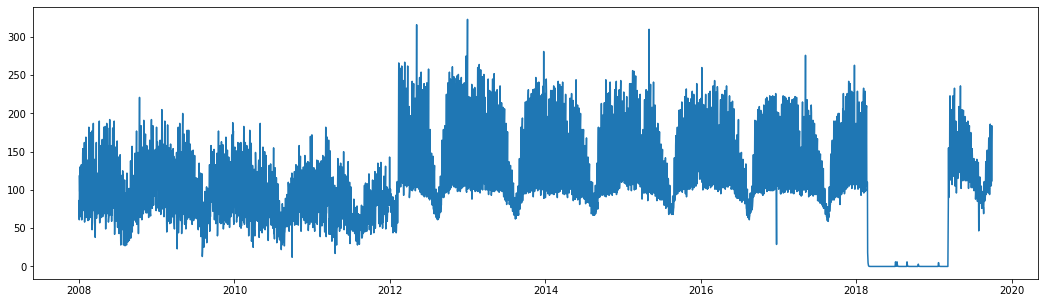

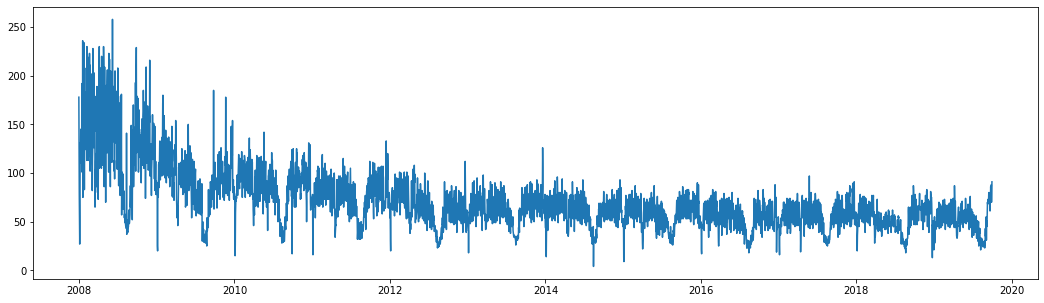

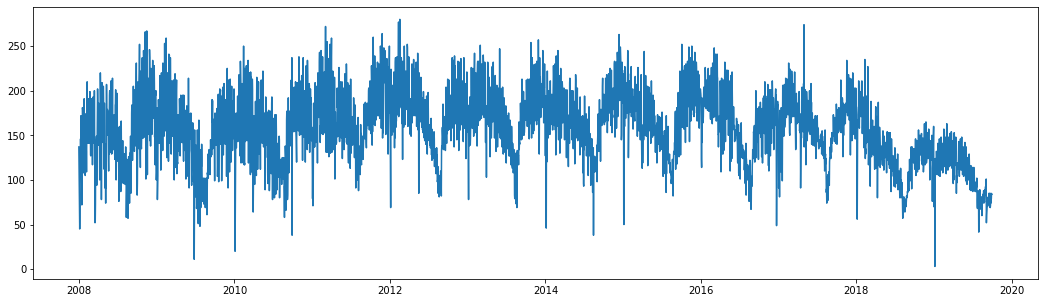

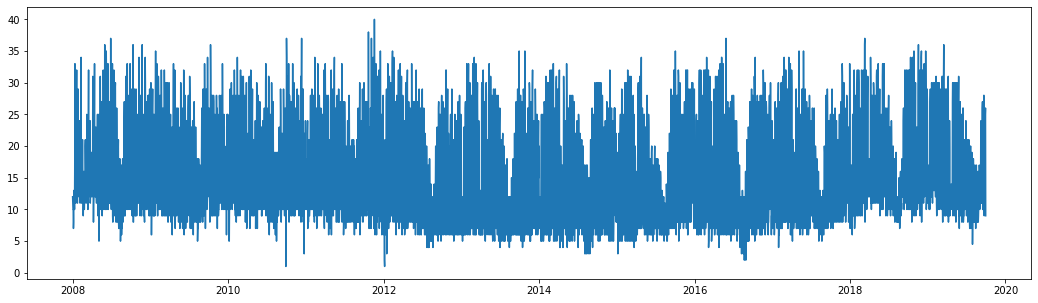

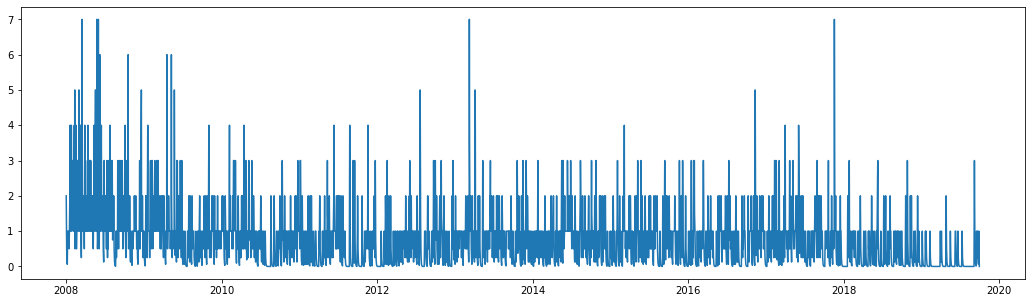

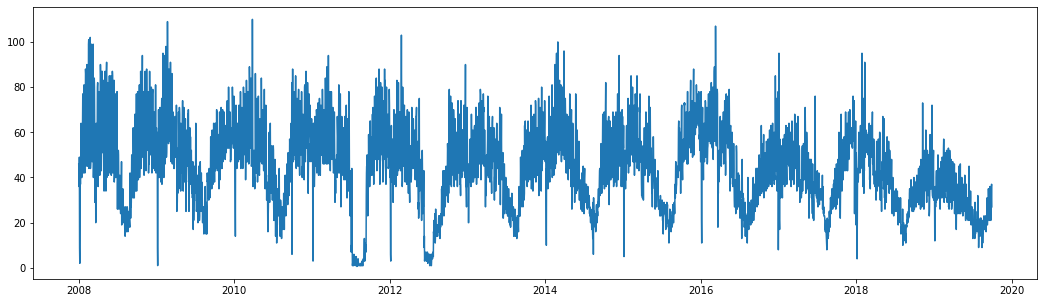

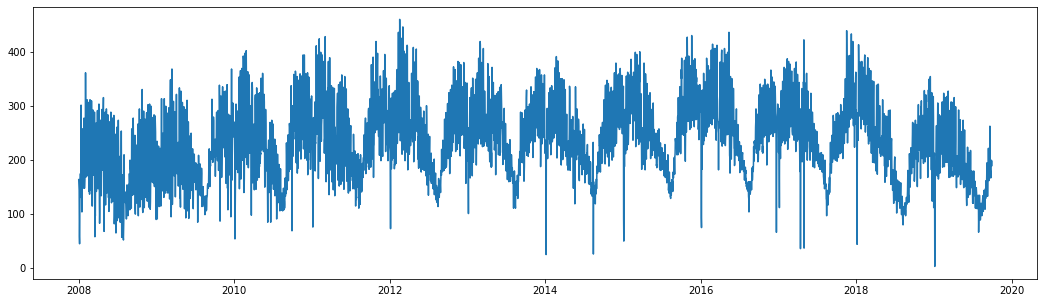

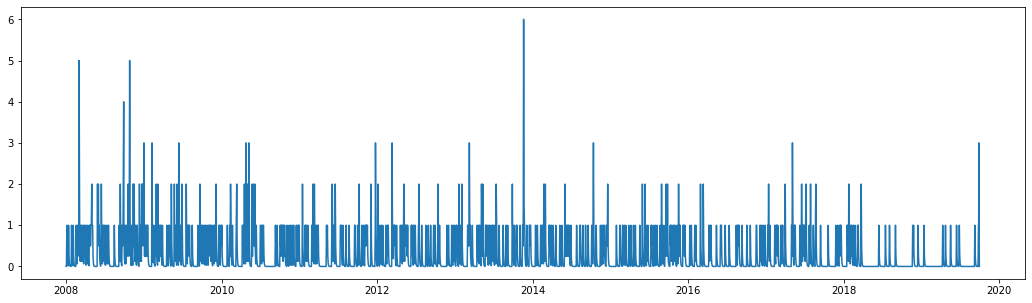

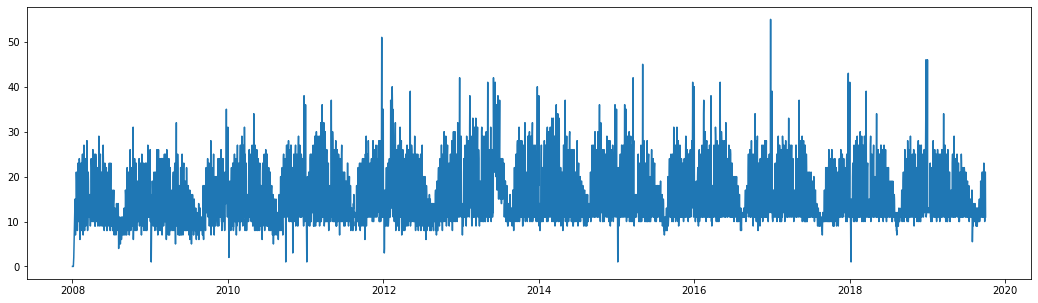

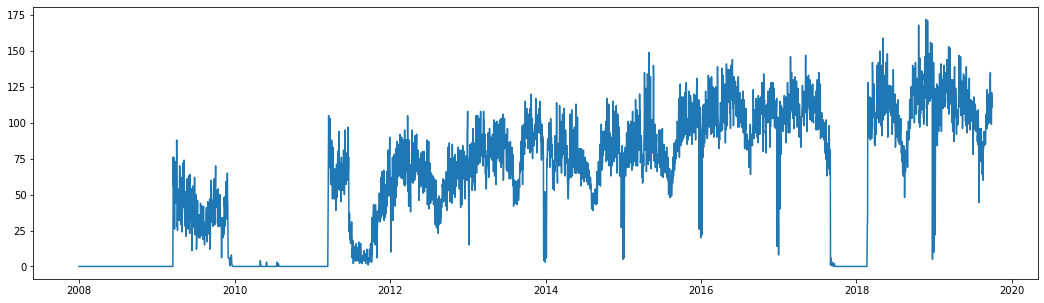

In [102]:
for producto in our_dataset['target_names_prod_by_prod'].unique():

    aaa = our_dataset[our_dataset['target_names_prod_by_prod']== producto].groupby('order_date')['units_ordered'].sum()

    for (index, value) in aaa.iteritems():
        
        
        if index != datetime.strptime('01-01-2008', '%d-%m-%Y') and index != datetime.strptime('30-09-2019', '%d-%m-%Y'):
            if value == 0:
                aaa[index] = (aaa[index + dt.timedelta(days=1)] + aaa[index + dt.timedelta(days=-1)])/2

    plt.figure(figsize = (18,5))

    plt.plot(aaa)

## 7. Storing the dataset<a id='a7'></a>

We now, lets rename the columns (something that we should have done a while ago), and store the dataset:

In [104]:
our_dataset.columns = ['order_date', 'product', 'store', 'units_ordered']

In [105]:
our_dataset.to_csv(exit_path_processed+exit_file, sep=sep, index=False)

## 8. Plotting the data<a id='a8'></a>

Finally, we now proceed to plot each and every time series, to take a first glance on what we are going to deal with:

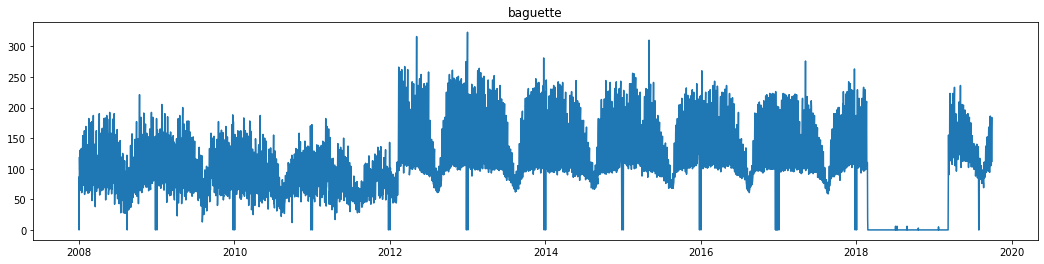

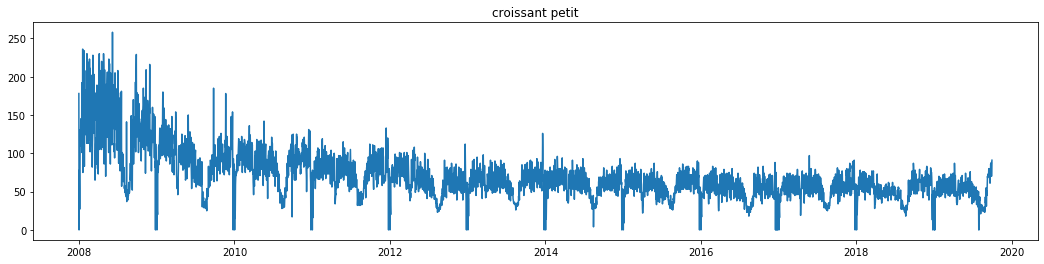

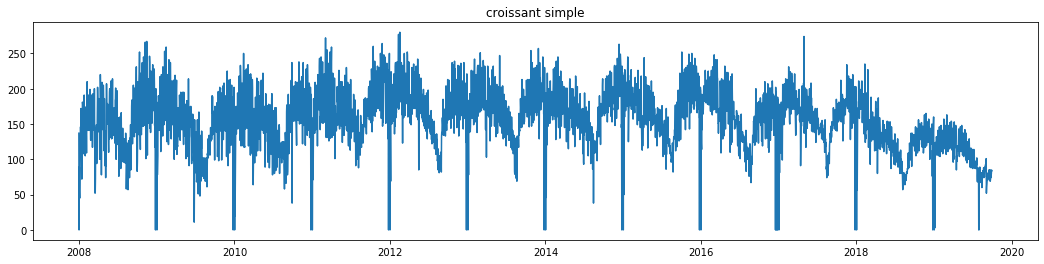

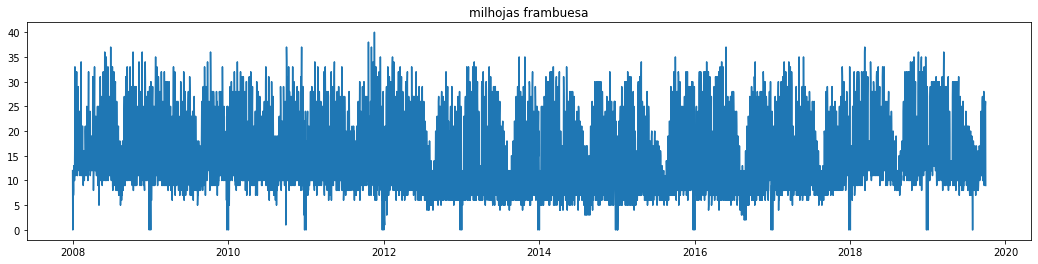

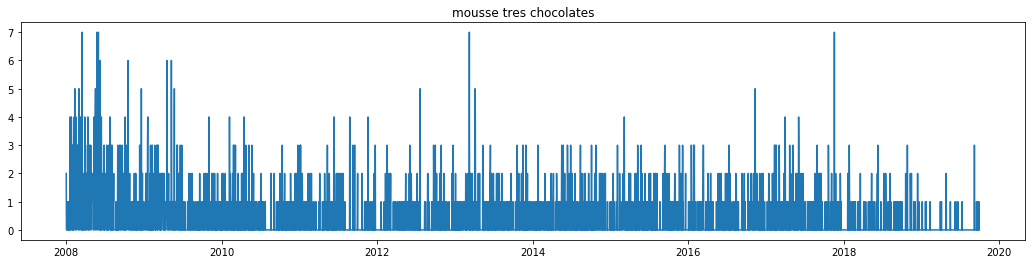

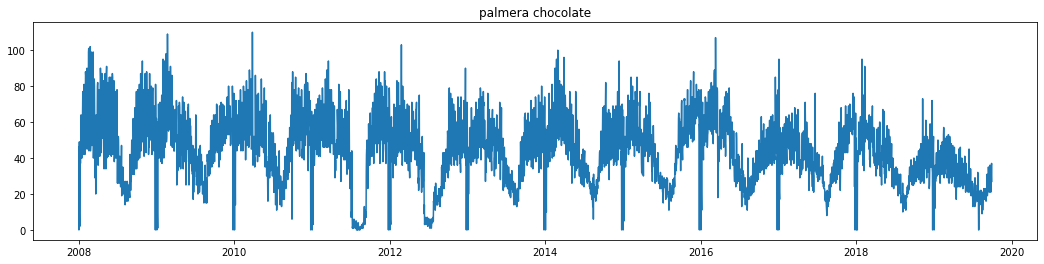

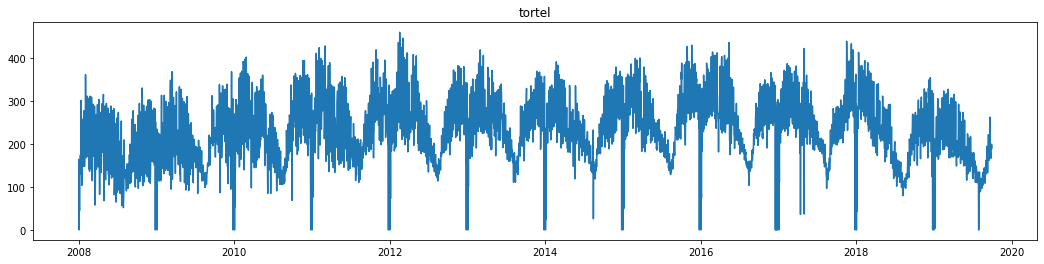

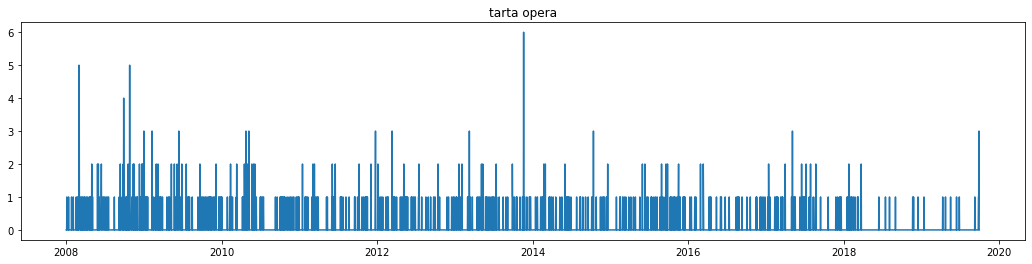

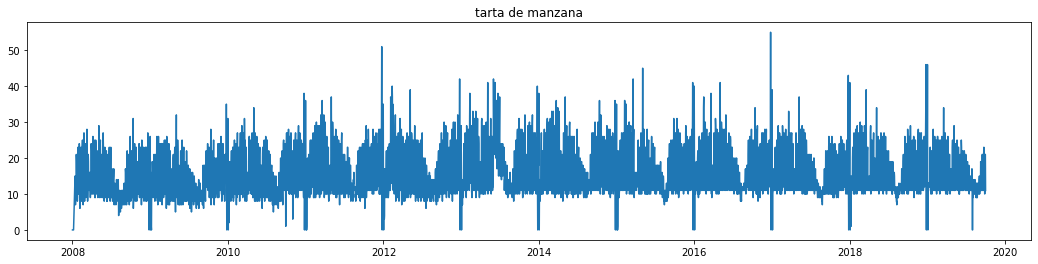

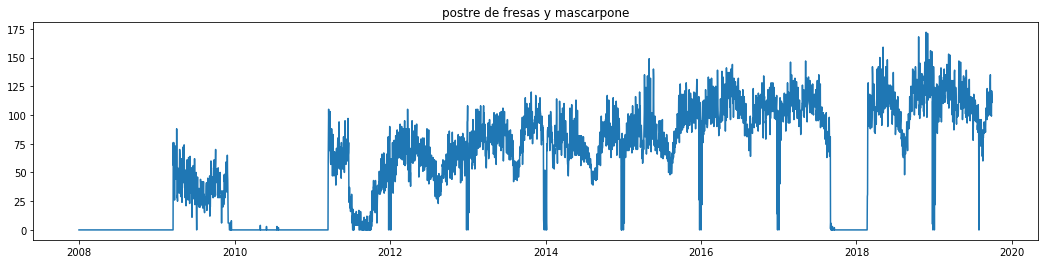

In [106]:
for product in our_dataset['product'].unique():

    series_to_plot = our_dataset[our_dataset['product']==product].groupby('order_date')['units_ordered'].sum()
    plt.figure(figsize=(18,4))
    plt.plot(series_to_plot)
    plt.title(product)
    plt.show()

In [107]:
our_dataset

,order_date,product,store,units_ordered
0,2008-01-01,baguette,AaUP,15.0
1,2008-01-01,baguette,AeUP,0.0
2,2008-01-01,baguette,AnUP,6.0
3,2008-01-01,baguette,BmUP,6.0
4,2008-01-01,baguette,CzUP,7.0
5,2008-01-01,baguette,EnUP,0.0
6,2008-01-01,baguette,GeUP,0.0
7,2008-01-01,baguette,GoUP,0.0
8,2008-01-01,baguette,GrUP,0.0
9,2008-01-01,baguette,JPUP,8.0


In [108]:
df_weekly = our_dataset.groupby([pd.Grouper(key='order_date', freq='W-MON'),"product"])['units_ordered'].sum().reset_index().sort_values('order_date')

In [109]:
df_weekly

,order_date,product,units_ordered
0,2008-01-07,baguette,621.0
1,2008-01-07,croissant petit,507.0
2,2008-01-07,croissant simple,474.0
3,2008-01-07,milhojas frambuesa,60.0
4,2008-01-07,mousse tres chocolates,2.0
5,2008-01-07,palmera chocolate,164.0
6,2008-01-07,postre de fresas y mascarpone,0.0
7,2008-01-07,tarta de manzana,2.0
8,2008-01-07,tarta opera,1.0
9,2008-01-07,tortel,667.0


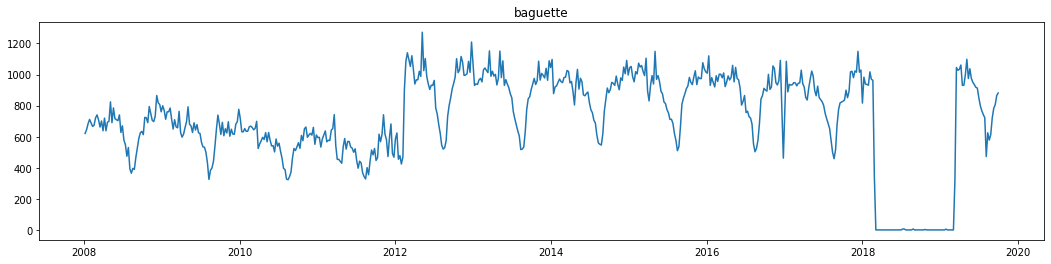

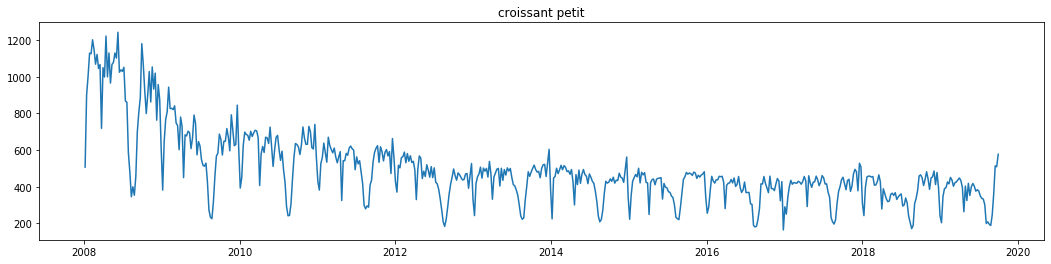

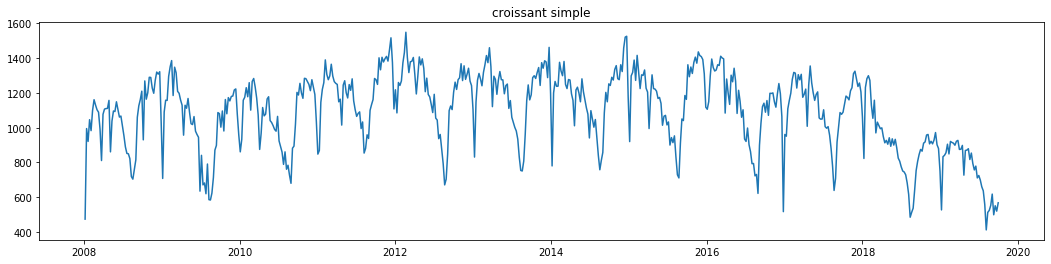

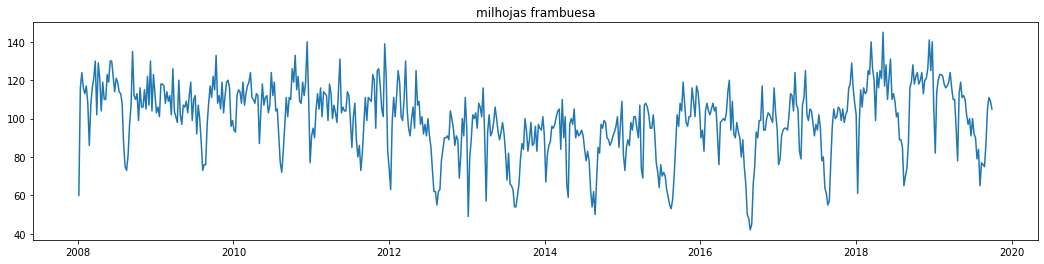

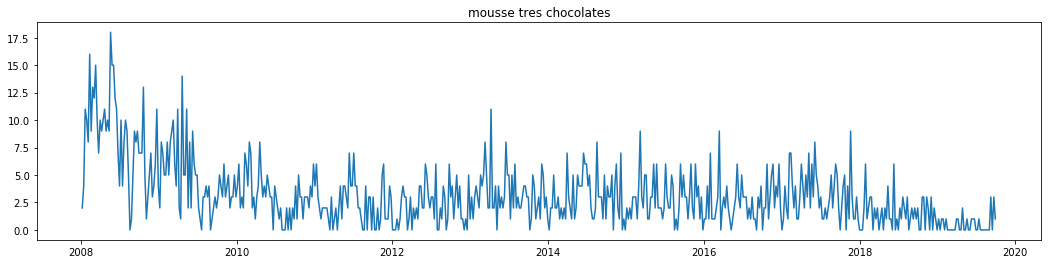

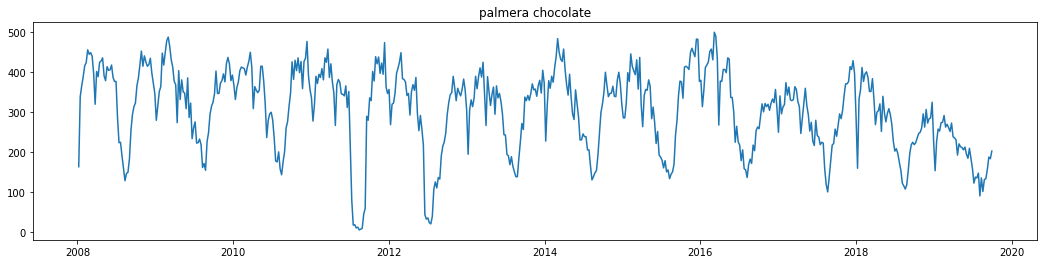

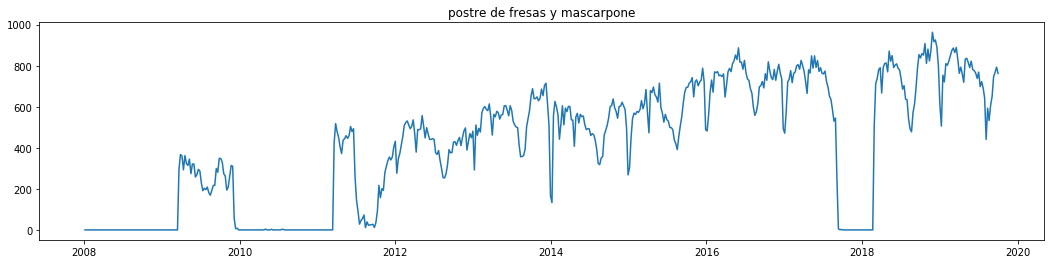

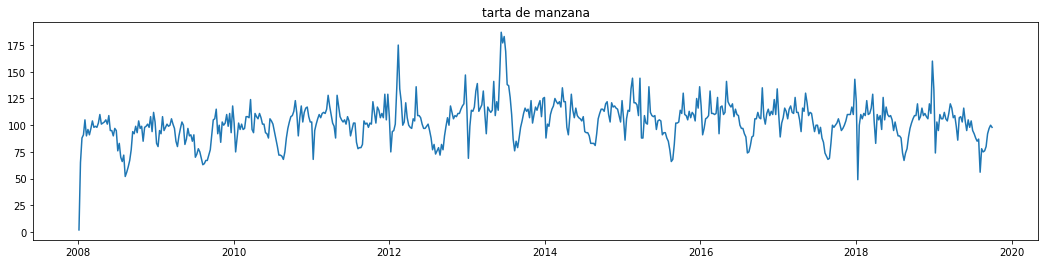

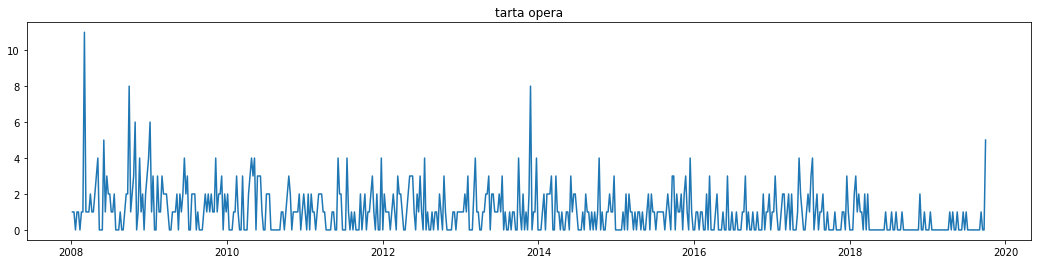

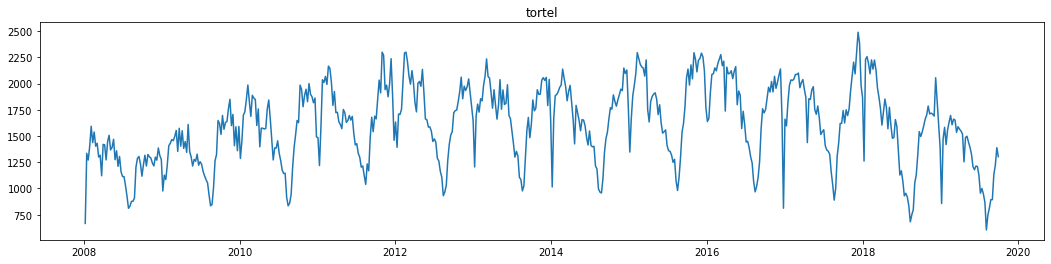

In [110]:
# Print weekly

for product in df_weekly['product'].unique():
    series_to_plot = df_weekly[df_weekly['product']==product].groupby('order_date')['units_ordered'].sum()
    plt.figure(figsize=(18,4))
    plt.plot(series_to_plot)
    plt.title(product)
    plt.show()